### Sales Forecasting using Stacked LightGBM and XGBoost for M5 Competition

This notebook implements a hybrid machine learning pipeline for the M5 Forecasting competition, blending the strengths of LightGBM and XGBoost models through stacking. The core logic of the notebook follows these stages:

1. **Data Loading and Preprocessing:** This notebook reads the official calendar, sell prices, and sales_train_validation datasets. Categorical columns (e.g., event_name_1, store_id, item_id) are encoded as integer categories for model compatibility and performance. Dates are parsed as datetime objects for lag feature engineering.

2. **Feature Engineering:** Core features include

    - Lag features: Past sales data (t-1, t-7, etc.) to capture recent trends.
    - Rolling statistics: 7-, 28-, and 56-day rolling means to smooth volatility.
    - Price dynamics: Features like price_max, price_std, and price_norm capture pricing behavior.
    - Calendar-based variables: Day-of-week, events, SNAP flag, etc., to embed external factors.

    The model focuses only on recent sales data (firstDay = 250) for performance optimization.

3. **Model Training:** 
    - Base models: LightGBM and XGBoost regressors are trained independently using identical features.
    - Meta model: A second-level LightGBM model is trained on the out-of-fold predictions from the base models, completing the stacking ensemble.

4. **Validation and Forecasting:** A hold-out validation set is constructed based on the final 28 days before the forecast horizon. The final submission predicts 28 days ahead (F1 to F28) for each id.

5. **Output:** The submission is generated in the required format for Kaggle, combining the model predictions into a structured submission.csv.

**Results:**

![WhatsApp Image 2025-05-04 at 14.27.49_8f262e58.jpg](<attachment:WhatsApp Image 2025-05-04 at 14.27.49_8f262e58.jpg>)
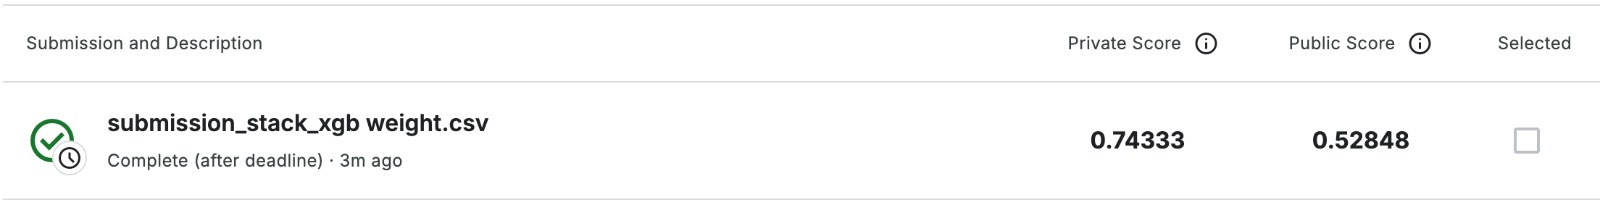

### Importing nessecary libraries

In [ ]:
# Importing Libraries
import gc
import numpy as np
import pandas as pd
import lightgbm as lgb
from  datetime import datetime, timedelta
import os
import joblib

### Data Preprocessing

In [16]:
# Loading and Preprocessing calendar.csv
calendarDTypes = {"event_name_1": "category", 
                  "event_name_2": "category", 
                  "event_type_1": "category", 
                  "event_type_2": "category", 
                  "weekday": "category", 
                  'wm_yr_wk': 'int16', 
                  "wday": "int16",
                  "month": "int16", 
                  "year": "int16", 
                  "snap_CA": "float32", 
                  'snap_TX': 'float32', 
                  'snap_WI': 'float32' }

# Read csv file
calendar = pd.read_csv("../input/m5-forecasting-accuracy/calendar.csv", 
                       dtype = calendarDTypes)

calendar["date"] = pd.to_datetime(calendar["date"])

# Transforming Categorical Features
for col, colDType in calendarDTypes.items():
    if colDType == "category":
        calendar[col] = calendar[col].cat.codes.astype("int16")
        calendar[col] -= calendar[col].min()

calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,2,1,1,2011,d_1,0,0,0,0,0.0,0.0,0.0
1,2011-01-30,11101,3,2,1,2011,d_2,0,0,0,0,0.0,0.0,0.0
2,2011-01-31,11101,1,3,1,2011,d_3,0,0,0,0,0.0,0.0,0.0
3,2011-02-01,11101,5,4,2,2011,d_4,0,0,0,0,1.0,1.0,0.0
4,2011-02-02,11101,6,5,2,2011,d_5,0,0,0,0,1.0,0.0,1.0


In [17]:
# Loading and Preprocessing sell_prices.csv
priceDTypes = {"store_id": "category", 
               "item_id": "category", 
               "wm_yr_wk": "int16",
               "sell_price":"float32"}

# Read csv file
prices = pd.read_csv("../input/m5-forecasting-accuracy/sell_prices.csv", 
                     dtype = priceDTypes)

# Transforming Categorical Features
for col, colDType in priceDTypes.items():
    if colDType == "category":
        prices[col] = prices[col].cat.codes.astype("int16")
        prices[col] -= prices[col].min()
        
prices.head()

,store_id,item_id,wm_yr_wk,sell_price
0,0,0,11325,9.58
1,0,0,11326,9.58
2,0,0,11327,8.26
3,0,0,11328,8.26
4,0,0,11329,8.26


In [ ]:
firstDay = 250 # to focus more on recent data
lastDay = 1913

# Use x sales days (columns) for training
numCols = [f"d_{day}" for day in range(firstDay, lastDay+1)]

# Define all categorical columns
catCols = ['id', 'item_id', 'dept_id','store_id', 'cat_id', 'state_id']

# Define the correct data types for "sales_train_validation.csv"
dtype = {numCol: "float32" for numCol in numCols} 
dtype.update({catCol: "category" for catCol in catCols if catCol != "id"})

# Read csv file
ds = pd.read_csv("../input/m5-forecasting-accuracy/sales_train_validation.csv", 
                 usecols = catCols + numCols, dtype = dtype)

# Transform categorical features into integers
for col in catCols:
    if col != "id":
        ds[col] = ds[col].cat.codes.astype("int16")
        ds[col] -= ds[col].min()

# Converting wide to long format        
ds = pd.melt(ds,
             id_vars = catCols,
             value_vars = [col for col in ds.columns if col.startswith("d_")],
             var_name = "d",
             value_name = "sales")

# Merge sales data with "calendar" and "prices" dataframe
ds = ds.merge(calendar, on = "d", copy = False)
ds = ds.merge(prices, on = ["store_id", "item_id", "wm_yr_wk"], copy = False)

ds.head()

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_002_CA_1_validation,1,0,0,0,0,d_250,0.0,2011-10-05,11136,...,10,2011,0,0,0,0,1.0,1.0,1.0,3.97
1,HOBBIES_1_004_CA_1_validation,3,0,0,0,0,d_250,0.0,2011-10-05,11136,...,10,2011,0,0,0,0,1.0,1.0,1.0,4.34
2,HOBBIES_1_005_CA_1_validation,4,0,0,0,0,d_250,0.0,2011-10-05,11136,...,10,2011,0,0,0,0,1.0,1.0,1.0,2.48
3,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_250,1.0,2011-10-05,11136,...,10,2011,0,0,0,0,1.0,1.0,1.0,0.50
4,HOBBIES_1_009_CA_1_validation,8,0,0,0,0,d_250,2.0,2011-10-05,11136,...,10,2011,0,0,0,0,1.0,1.0,1.0,1.77


### Feature Engineering

In [19]:
#Lag and Rolling Mean Features
dayLags = [7, 28]
lagSalesCols = [f"lag_{dayLag}" for dayLag in dayLags]
for dayLag, lagSalesCol in zip(dayLags, lagSalesCols):
    ds[lagSalesCol] = ds[["id","sales"]].groupby("id")["sales"].shift(dayLag)
    
windows = [7, 28]
for window in windows:
    for dayLag, lagSalesCol in zip(dayLags, lagSalesCols):
        ds[f"rmean_{dayLag}_{window}"] = ds[["id", lagSalesCol]].groupby("id")[lagSalesCol].transform(lambda x: x.rolling(window).mean())

In [20]:
dateFeatures = {
    "wday": "weekday",
    "month": "month",
    "quarter": "quarter",
    "year": "year",
    "mday": "day"
}

for featName, featFunc in dateFeatures.items():
    if featName in ds.columns:
        ds[featName] = ds[featName].astype("int16")
    else:
        ds[featName] = getattr(ds["date"].dt, featFunc).astype("int16")

# Special handling for 'week'
ds["week"] = ds["date"].dt.isocalendar().week.astype("int16")


In [21]:
ds.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,...,sell_price,lag_7,lag_28,rmean_7_7,rmean_28_7,rmean_7_28,rmean_28_28,quarter,mday,week
0,HOBBIES_1_002_CA_1_validation,1,0,0,0,0,d_250,0.0,2011-10-05,11136,...,3.97,NaN,NaN,NaN,NaN,NaN,NaN,4,5,40
1,HOBBIES_1_004_CA_1_validation,3,0,0,0,0,d_250,0.0,2011-10-05,11136,...,4.34,NaN,NaN,NaN,NaN,NaN,NaN,4,5,40
2,HOBBIES_1_005_CA_1_validation,4,0,0,0,0,d_250,0.0,2011-10-05,11136,...,2.48,NaN,NaN,NaN,NaN,NaN,NaN,4,5,40
3,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_250,1.0,2011-10-05,11136,...,0.50,NaN,NaN,NaN,NaN,NaN,NaN,4,5,40
4,HOBBIES_1_009_CA_1_validation,8,0,0,0,0,d_250,2.0,2011-10-05,11136,...,1.77,NaN,NaN,NaN,NaN,NaN,NaN,4,5,40


In [22]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42372682 entries, 0 to 42372681
Data columns (total 31 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            object        
 1   item_id       int16         
 2   dept_id       int16         
 3   store_id      int16         
 4   cat_id        int16         
 5   state_id      int16         
 6   d             object        
 7   sales         float32       
 8   date          datetime64[ns]
 9   wm_yr_wk      int16         
 10  weekday       int16         
 11  wday          int16         
 12  month         int16         
 13  year          int16         
 14  event_name_1  int16         
 15  event_type_1  int16         
 16  event_name_2  int16         
 17  event_type_2  int16         
 18  snap_CA       float32       
 19  snap_TX       float32       
 20  snap_WI       float32       
 21  sell_price    float32       
 22  lag_7         float32       
 23  lag_28        float32       
 

### Data clean up and training split

In [23]:
# Remove all rows with NaN value
ds.dropna(inplace = True)

# Define columns that need to be removed
unusedCols = ["id", "date", "sales","d", "wm_yr_wk", "weekday"]
trainCols = ds.columns[~ds.columns.isin(unusedCols)]
X_train = ds[trainCols]
y_train = ds["sales"]

### Model Training: Light GBM

In [24]:
np.random.seed(777)

# Define categorical features
catFeats = ['item_id', 'dept_id','store_id', 'cat_id', 'state_id'] + \
           ["event_name_1", "event_name_2", "event_type_1", "event_type_2"]

validInds = np.random.choice(X_train.index.values, 2_000_000, replace = False)
trainInds = np.setdiff1d(X_train.index.values, validInds)

trainData = lgb.Dataset(X_train.loc[trainInds], label = y_train.loc[trainInds], 
                        categorical_feature = catFeats, free_raw_data = False)
validData = lgb.Dataset(X_train.loc[validInds], label = y_train.loc[validInds],
                        categorical_feature = catFeats, free_raw_data = False)

### Model Evaluation: Light GBM

In [25]:
# Last day used for training
trLast = 1913
# Maximum lag day
maxLags = 57

# Create dataset for predictions
def create_ds():
    
    startDay = trLast - maxLags
    
    numCols = [f"d_{day}" for day in range(startDay, trLast + 1)]
    catCols = ['id', 'item_id', 'dept_id','store_id', 'cat_id', 'state_id']
    
    dtype = {numCol:"float32" for numCol in numCols} 
    dtype.update({catCol: "category" for catCol in catCols if catCol != "id"})
    
    ds = pd.read_csv("../input/m5-forecasting-accuracy/sales_train_validation.csv", 
                     usecols = catCols + numCols, dtype = dtype)
    
    for col in catCols:
        if col != "id":
            ds[col] = ds[col].cat.codes.astype("int16")
            ds[col] -= ds[col].min()
    
    for day in range(trLast + 1, trLast+ 28 +1):
        ds[f"d_{day}"] = np.nan
    
    ds = pd.melt(ds,
                 id_vars = catCols,
                 value_vars = [col for col in ds.columns if col.startswith("d_")],
                 var_name = "d",
                 value_name = "sales")
    
    ds = ds.merge(calendar, on = "d", copy = False)
    ds = ds.merge(prices, on = ["store_id", "item_id", "wm_yr_wk"], copy = False)
    
    return ds



In [ ]:
#create features for prediction data
def create_features(ds):          
    dayLags = [7, 28]
    lagSalesCols = [f"lag_{dayLag}" for dayLag in dayLags]
    for dayLag, lagSalesCol in zip(dayLags, lagSalesCols):
        ds[lagSalesCol] = ds[["id", "sales"]].groupby("id")["sales"].shift(dayLag)

    windows = [7, 28]
    for window in windows:
        for dayLag, lagSalesCol in zip(dayLags, lagSalesCols):
            ds[f"rmean_{dayLag}_{window}"] = ds[["id", lagSalesCol]].groupby("id")[lagSalesCol].transform(lambda x: x.rolling(window).mean())

    dateFeatures = {
        "wday": "weekday",
        "month": "month",
        "quarter": "quarter",
        "year": "year",
        "mday": "day"
    }

    for featName, featFunc in dateFeatures.items():
        if featName in ds.columns:
            ds[featName] = ds[featName].astype("int16")
        else:
            ds[featName] = getattr(ds["date"].dt, featFunc).astype("int16")

    # FIXED: Add week manually
    ds["week"] = ds["date"].dt.isocalendar().week.astype("int16")


In [ ]:
for root, dirs, files in os.walk("/kaggle/input"):
    for name in files:
        print(os.path.join(root, name))

/kaggle/input/m5-forecasting-accuracy/calendar.csv
/kaggle/input/m5-forecasting-accuracy/sample_submission.csv
/kaggle/input/m5-forecasting-accuracy/sell_prices.csv
/kaggle/input/m5-forecasting-accuracy/sales_train_validation.csv
/kaggle/input/m5-forecasting-accuracy/sales_train_evaluation.csv
/kaggle/input/model.lgb/other/default/1/model.lgb
/kaggle/input/xgb_model.pkl/other/default/1/xgb_model.pkl


### Loading the created models

The XGBoost model is trained in a separate notebook to mitigate memory issues on Kaggle. In this notebook the trained model is stacked with Light GBM to get final predictions.

In [ ]:
m_lgb = lgb.Booster(model_file="/kaggle/input/model.lgb/other/default/1/model.lgb")

In [ ]:
xgb_model = joblib.load("/kaggle/input/xgb_model.pkl/other/default/1/xgb_model.pkl")

In [ ]:
# ========================
# Forecasting with weighted stacking
# ========================
fday = datetime(2016, 4, 25)
alphas = [1.028, 1.023, 1.018]
weights = [1 / len(alphas)] * len(alphas)
sub = 0.
cols = [f"F{i}" for i in range(1, 29)]

for icount, (alpha, weight) in enumerate(zip(alphas, weights)):
    te = create_ds()
    for tdelta in range(28):
        day = fday + timedelta(days=tdelta)
        print(tdelta, day)
        tst = te[(te["date"] >= day - timedelta(days=57)) & (te["date"] <= day)].copy()
        create_features(tst)

        tst_today = tst.loc[tst["date"] == day, trainCols]

        # Check to avoid predicting on empty df
        if tst_today.empty:
            continue

        # Weighted model stacking
        lgb_preds = alpha * m_lgb.predict(tst_today)
        xgb_preds = xgb_model.predict(tst_today)

        final_preds = 0.89 * lgb_preds + 0.11 * xgb_preds

        te.loc[te["date"] == day, "sales"] = final_preds

    te_sub = te.loc[te["date"] >= fday, ["id", "sales"]].copy()
    te_sub["F"] = [f"F{rank}" for rank in te_sub.groupby("id")["id"].cumcount() + 1]
    te_sub = te_sub.set_index(["id", "F"]).unstack()["sales"][cols].reset_index()
    te_sub.fillna(0., inplace=True)
    te_sub.sort_values("id", inplace=True)
    te_sub.reset_index(drop=True, inplace=True)

    if icount == 0:
        sub = te_sub
        sub[cols] *= weight
    else:
        sub[cols] += te_sub[cols] * weight
    print(icount, alpha, weight)

# Duplicate for evaluation set
sub2 = sub.copy()
sub2["id"] = sub2["id"].str.replace("validation$", "evaluation")
sub = pd.concat([sub, sub2], axis=0, sort=False)
sub.to_csv("submission.csv", index=False)
print("submission.csv with weighted stacked predictions created.")

0 2016-04-25 00:00:00
1 2016-04-26 00:00:00
2 2016-04-27 00:00:00
3 2016-04-28 00:00:00
4 2016-04-29 00:00:00
5 2016-04-30 00:00:00
6 2016-05-01 00:00:00
7 2016-05-02 00:00:00
8 2016-05-03 00:00:00
9 2016-05-04 00:00:00
10 2016-05-05 00:00:00
11 2016-05-06 00:00:00
12 2016-05-07 00:00:00
13 2016-05-08 00:00:00
14 2016-05-09 00:00:00
15 2016-05-10 00:00:00
16 2016-05-11 00:00:00
17 2016-05-12 00:00:00
18 2016-05-13 00:00:00
19 2016-05-14 00:00:00
20 2016-05-15 00:00:00
21 2016-05-16 00:00:00
22 2016-05-17 00:00:00
23 2016-05-18 00:00:00
24 2016-05-19 00:00:00
25 2016-05-20 00:00:00
26 2016-05-21 00:00:00
27 2016-05-22 00:00:00
0 1.028 0.3333333333333333
0 2016-04-25 00:00:00
1 2016-04-26 00:00:00
2 2016-04-27 00:00:00
3 2016-04-28 00:00:00
4 2016-04-29 00:00:00
5 2016-04-30 00:00:00
6 2016-05-01 00:00:00
7 2016-05-02 00:00:00
8 2016-05-03 00:00:00
9 2016-05-04 00:00:00
10 2016-05-05 00:00:00
11 2016-05-06 00:00:00
12 2016-05-07 00:00:00
13 2016-05-08 00:00:00
14 2016-05-09 00:00:00
15 2